In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from hubmap.visualization import visualize_checkpoint
from hubmap.visualization import visualize_random_image, ImageType
from hubmap.visualization import visualize_image
from hubmap.models import DPT
from hubmap.models.dpt import Backbone

from hubmap.dataset import BaseDataset
from hubmap.data import DATA_DIR
import hubmap.dataset.transforms as T

In [42]:
ckpt = "fct_trial_batch_size_64_img_size_256.pt"

(<Figure size 400x400 with 1 Axes>, <Figure size 400x400 with 1 Axes>)

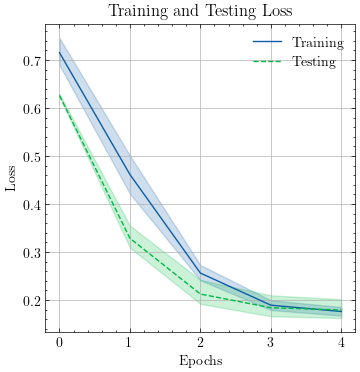

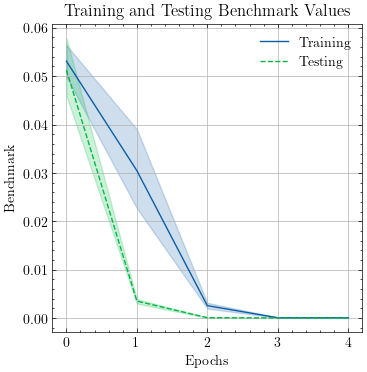

In [43]:
visualize_checkpoint(ckpt)

In [44]:
transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((256, 256)),
    ]
)
model_transforms = T.Compose(
    [
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset = BaseDataset(DATA_DIR, transform=None, with_background=True)
image, target = dataset.get(0, transform=transforms)

In [60]:
from hubmap.models import FCT
from hubmap.models import init_weights

model = FCT(in_channels=3, num_classes=4)
model.apply(init_weights)

_ = visualize_image(model, ckpt, image, target, transforms=model_transforms, pred_idx=2)

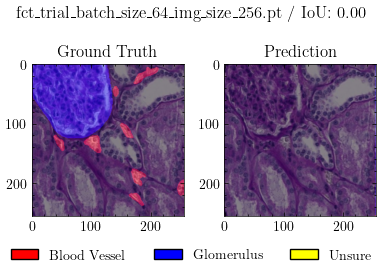

In [58]:
_ = visualize_image(
    model, ckpt, image, target, transforms=model_transforms, pred_idx=2, overlay=True
)